In [9]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
% load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
library(arm)
library(reshape2)

In [12]:
%%R
library(ggplot2)

In [13]:
%%R
library(caret)

In [14]:
%%R
base <- read.table("df1.csv", sep =",",header=TRUE)
#load("RData")

In [15]:
%%R
load("Label2.RData")

In [16]:
%%R
#Lift curve is the plot between total lift and %population
# True label: label
# Predicted label: Predict
# largest P according to the sort order of the submission

#######The lift chart shows how much more likely we are to receive positive responses than 
#######if we contact a random sample of customers. For example, by contacting only 10% of 
#######customers based on the predictive model we will reach 3 times as many respondents, 
#######as if we use no model.
takeTopP  <- function(df, p) {
  df  <- df[order(df$predict, decreasing = T),]
  numToTake = ceiling(p*nrow(df))
  return(df[1:numToTake,])
}

liftvalue <- function(df,p){
  top <- takeTopP(df,p)
  lift_value <- sum(top$label) /(p*sum(df$label))
  return(lift_value)
}

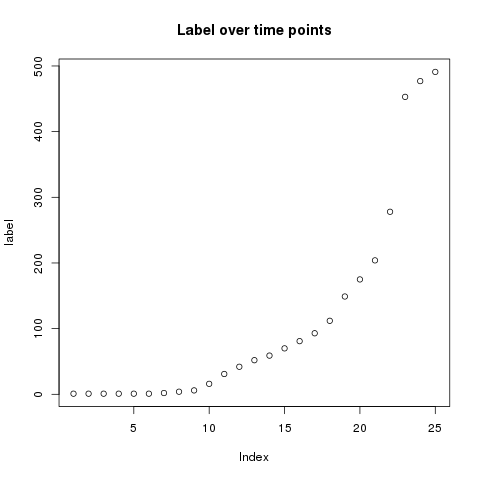

In [17]:
%%R
label <- rep(0,25)
for (i in 1:25){
  label[i] <- table(label_list[[i]])[2]
}
plot(label,main="Label over time points")

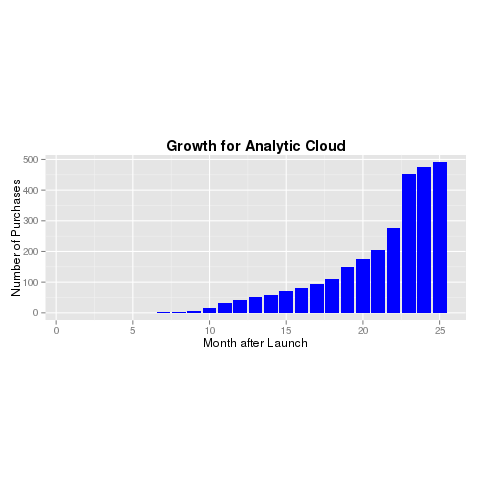

In [18]:
%%R
x <- seq(1, 25, 1)
df1 <- data.frame(x,label)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
#ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggplot(data = df2, aes(x = x, y = value)) + geom_bar(stat = "identity", fill="blue") + 
ggtitle("Growth for Analytic Cloud") + theme(plot.title = element_text(lineheight=.8, face="bold"))+ 
labs(x = "Month after Launch", y="Number of Purchases")+ coord_fixed(ratio=0.02)

In [19]:
%%R
####Remove the initial positive accounts
initial <- unlist(label_list[1])
remove_initial <- which(initial==1)
label_update <- vector("list", 25)
for (i in 1:25){
  label_update[[i]] <- label_list[[i]][-remove_initial]
}
#testlabel <- last[-remove_initial]
#testing <- base_s[-remove_initial,]

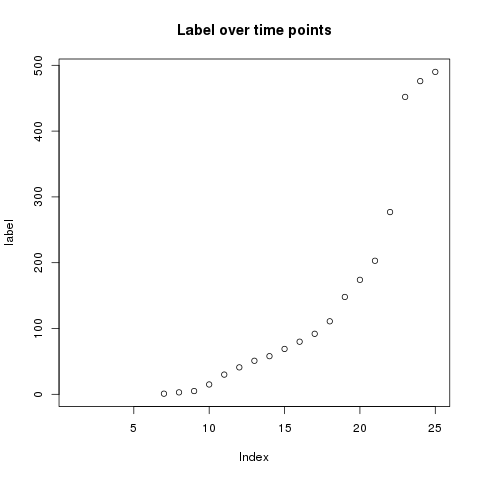

In [20]:
%%R
label <- rep(0,25)
for (i in 1:25){
  label[i] <- table(label_update[[i]])[2]
}
plot(label,main="Label over time points")

In [21]:
%%R
#extract numeric features
features <- base[c("NUM_USERS","NUM_ACCOUNTS","NUM_CONTACTS","NUM_OPPTS","NUM_FORECASTS","NUM_REPORTS","NUM_LEADS",
                       "NUM_CASES","NUM_SOLUTIONS","NUM_CASE_QUEUES","NUM_CAMPAIGNS","NUM_CUSTOM_APPS","NUM_CUSTOM_TABS", 
                       "NUM_CUSTOM_OBJECTS","NUM_CUSTOM_OBJECT_RECORDS","NUM_DOCUMENTS","NUM_CONTRACTS",
                       "NUM_CASE_RECORD_TYPES","NUM_ESCALATION_RULES","NUM_DASHBOARDS","NUM_EMAIL_TEMPLATES","NUM_VF_PG_TOT")]

In [22]:
%%R
#Log transform the numeric variables
log_trans <- function(var){
    logvar <- log(var+1)
    return(logvar)
}
features <- apply(features, 2, log_trans)

In [23]:
%%R
#first scaling all nonbinary variables to have mean 0 and standard deviation 0.5
bayesscale<- function(myVar){
  zVar <-0.5* (myVar - mean(myVar)) / sd(myVar)
  return(zVar)
}
#base
base_s <- apply(features,2,bayesscale)
base_s <- data.frame(base_s)

In [25]:
%%R
base_s <- base_s[-remove_initial,]

In [26]:
%%R
######################################################
##############################split the dataset#######
######################################################
# Leave out labels in 2016 as testing set to get lift score
# Label2[21]: "2016-01-01" 204;    Label2[24]: "2016-03-31" 477
# 273 labels in 2016
testlabel <- rep(0,dim(base_s)[1])
last <- unlist(label_update[25])
first <- unlist(label_update[21])
#testlabel[last==1 & first==0]=1
#table(testlabel)

#testlabel[first==0]




#testingpostive <- cbind(base_s,testlabel)
#testingpostive <- testingpostive[testingpostive$testlabel==1,]# 288*29

#negative <- cbind(base_s,last)
#negative <- negative[negative$last==0,]

#names(negative)[names(negative)=="last"] <- "testlabel"

#testing <- rbind(testingpostive, negative)

# For negative users, 80% for training, 20% for testing
#inTrain <- createDataPartition(y=negative$NUM_ACCOUNTS,p=0.8,list=F)
#negativetraining <- negative[inTrain,]   #223970*29
#negativetesting <- negative[-inTrain,]   #55990*29


In [27]:
%%R
remove <- which(first==1)

In [28]:
%%R
testlabel <- last[-remove]
testing <- base_s[-remove,]
dim(testing)
testing <- cbind(testing, testlabel)

In [29]:
%%R
dim(base_s)
sum(testlabel)

[1] 287


In [30]:
%%R
base2 <- testing
base2$label <- testing$testlabel

In [31]:
%%R
base2$label <- as.factor(base2$label)

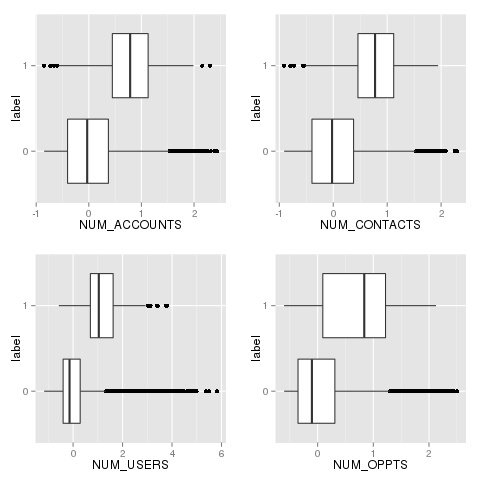

In [35]:
%%R
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)
  
  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  
  numPlots = length(plots)
  
  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))
  }
  
  if (numPlots==1) {
    print(plots[[1]])
    
  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

#par(mfrow=c(2,2))
#layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE))
p1 <- ggplot(base2, aes(x = label, y = NUM_ACCOUNTS)) + geom_boxplot() + coord_flip()
p2 <- ggplot(base2, aes(x = label, y = NUM_USERS)) + geom_boxplot() + coord_flip()
p3 <- ggplot(base2, aes(x = label, y = NUM_CONTACTS)) + geom_boxplot() + coord_flip()
p4 <- ggplot(base2, aes(x = label, y = NUM_OPPTS)) + geom_boxplot() + coord_flip()
multiplot(p1, p2, p3, p4, cols=2)

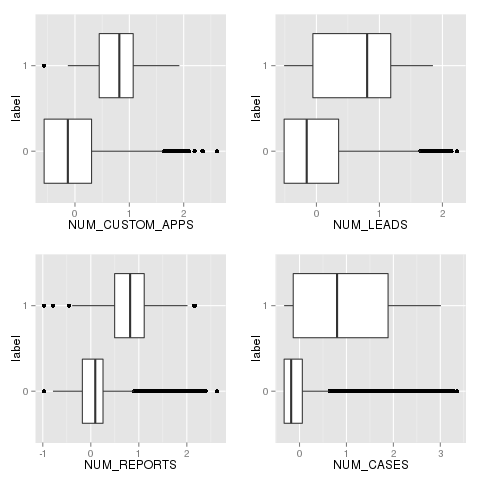

In [37]:
%%R
#par(mfrow=c(2,2))
#layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE))
p5 <- ggplot(base2, aes(x = label, y = NUM_CUSTOM_APPS)) + geom_boxplot() + coord_flip()
p6 <- ggplot(base2, aes(x = label, y = NUM_REPORTS)) + geom_boxplot() + coord_flip()
p7 <- ggplot(base2, aes(x = label, y = NUM_LEADS)) + geom_boxplot() + coord_flip()
p8 <- ggplot(base2, aes(x = label, y = NUM_CASES)) + geom_boxplot() + coord_flip()
multiplot(p5, p6, p7, p8, cols=2)

In [39]:
%%R
# Why Bayes?
#Prior information can allow for reasonable inference with moderate samples
#Allows for a wider class of applicable inference than frequency interpretation of probability
#Intuitive interpretation
# bayesglm with gaussian family (bayes lm)
############before split the data for testing#########
######################################################
####this should be identical to classical logit#######
######################################################

NULL


In [38]:
%%R
#############after split the data for testing#########
######################################################
####this should be identical to classical logit#######
######################################################
model2 <- bayesglm(formula = label_update[[1]] ~ NUM_ACCOUNTS + NUM_CONTACTS + NUM_OPPTS + NUM_FORECASTS
                   + NUM_REPORTS + NUM_LEADS + NUM_CASES + NUM_SOLUTIONS +NUM_CASE_QUEUES + NUM_CAMPAIGNS
                   + NUM_CUSTOM_APPS + NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS
                   + NUM_DOCUMENTS + NUM_CONTRACTS +NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES
                   + NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", data = base_s, 
                   maxit=100,prior.scale=Inf, prior.df=Inf)
display(model2)
predicted1 <- predict(model2, testing, type="response")
base2 <- testing
base2$label <- testing$testlabel
base2$predict <- predicted1
liftvalue(base2,0.1) 

bayesglm(formula = label_update[[1]] ~ NUM_ACCOUNTS + NUM_CONTACTS + 
    NUM_OPPTS + NUM_FORECASTS + NUM_REPORTS + NUM_LEADS + NUM_CASES + 
    NUM_SOLUTIONS + NUM_CASE_QUEUES + NUM_CAMPAIGNS + NUM_CUSTOM_APPS + 
    NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS + 
    NUM_DOCUMENTS + NUM_CONTRACTS + NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES + 
    NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", 
    data = base_s, prior.scale = Inf, prior.df = Inf, maxit = 100)
                          coef.est coef.se
(Intercept)               -14.93     3.23 
NUM_ACCOUNTS                0.00    14.62 
NUM_CONTACTS                0.00    14.48 
NUM_OPPTS                   0.00    10.55 
NUM_FORECASTS               0.00     7.06 
NUM_REPORTS                 0.00    16.54 
NUM_LEADS                   0.00     9.45 
NUM_CASES                   0.00    11.23 
NUM_SOLUTIONS               0.00    11.74 
NUM_CASE_QUEUES             0.00     7.43 
NUM_CAMPAI

In [40]:
%%R
liftscore <- rep(0,20)
#model1 <- vector("list", 20)
predicted <- vector("list", 20)
#base2 <- vector("list", 20)
for (i in 1:20){
    model2 <- bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + NUM_OPPTS + NUM_FORECASTS
                   + NUM_REPORTS + NUM_LEADS + NUM_CASES + NUM_SOLUTIONS +NUM_CASE_QUEUES + NUM_CAMPAIGNS
                   + NUM_CUSTOM_APPS + NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS
                   + NUM_DOCUMENTS + NUM_CONTRACTS +NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES
                   + NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", data = base_s, 
                   maxit=100,prior.scale=Inf, prior.df=Inf)
    display(model2)
    predicted1 <- predict(model2, testing, type="response")
    base2 <- testing
    base2$label <- testing$testlabel
    base2$predict <- predicted1
    print(liftvalue(base2,0.1)) 
    liftscore[i] <- liftvalue(base2,0.1)
}

bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + 
    NUM_OPPTS + NUM_FORECASTS + NUM_REPORTS + NUM_LEADS + NUM_CASES + 
    NUM_SOLUTIONS + NUM_CASE_QUEUES + NUM_CAMPAIGNS + NUM_CUSTOM_APPS + 
    NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS + 
    NUM_DOCUMENTS + NUM_CONTRACTS + NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES + 
    NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", 
    data = base_s, prior.scale = Inf, prior.df = Inf, maxit = 100)
                          coef.est coef.se
(Intercept)               -14.93     3.23 
NUM_ACCOUNTS                0.00    14.62 
NUM_CONTACTS                0.00    14.48 
NUM_OPPTS                   0.00    10.55 
NUM_FORECASTS               0.00     7.06 
NUM_REPORTS                 0.00    16.54 
NUM_LEADS                   0.00     9.45 
NUM_CASES                   0.00    11.23 
NUM_SOLUTIONS               0.00    11.74 
NUM_CASE_QUEUES             0.00     7.43 
NUM_CAMPAI

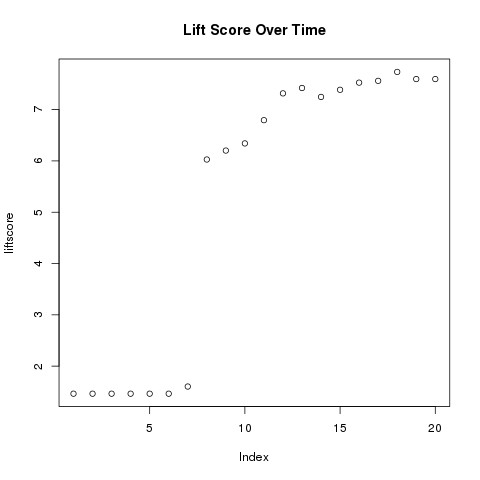

In [43]:
%%R
plot(liftscore,main='Lift Score Over Time')
# At time point 7, when the number of labels increases from 2 to 3, the lift score jumps to 10.

In [44]:
%%R
liftscore_cauchy <- rep(0,20)
#model1 <- vector("list", 20)
predicted_cauchy <- vector("list", 20)
#base2 <- vector("list", 20)
for (i in 1:20){
    model <- bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + NUM_OPPTS + NUM_FORECASTS
                   + NUM_REPORTS + NUM_LEADS + NUM_CASES + NUM_SOLUTIONS +NUM_CASE_QUEUES + NUM_CAMPAIGNS
                   + NUM_CUSTOM_APPS + NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS
                   + NUM_DOCUMENTS + NUM_CONTRACTS +NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES
                   + NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", data = base_s, 
                   maxit=100,prior.scale=2.5, prior.df=1)
    display(model)
    predicted1 <- predict(model, testing, type="response")
    base2 <- testing
    base2$label <- testing$testlabel
    base2$predict <- predicted1
    print(liftvalue(base2,0.1)) 
    liftscore_cauchy[i] <- liftvalue(base2,0.1)
}

bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + 
    NUM_OPPTS + NUM_FORECASTS + NUM_REPORTS + NUM_LEADS + NUM_CASES + 
    NUM_SOLUTIONS + NUM_CASE_QUEUES + NUM_CAMPAIGNS + NUM_CUSTOM_APPS + 
    NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS + 
    NUM_DOCUMENTS + NUM_CONTRACTS + NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES + 
    NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", 
    data = base_s, prior.scale = 2.5, prior.df = 1, maxit = 100)
                          coef.est coef.se
(Intercept)               -14.93     3.23 
NUM_ACCOUNTS                0.00     2.28 
NUM_CONTACTS                0.00     2.28 
NUM_OPPTS                   0.00     2.28 
NUM_FORECASTS               0.00     2.24 
NUM_REPORTS                 0.00     2.30 
NUM_LEADS                   0.00     2.27 
NUM_CASES                   0.00     2.28 
NUM_SOLUTIONS               0.00     2.27 
NUM_CASE_QUEUES             0.00     2.25 
NUM_CAMPAIGN

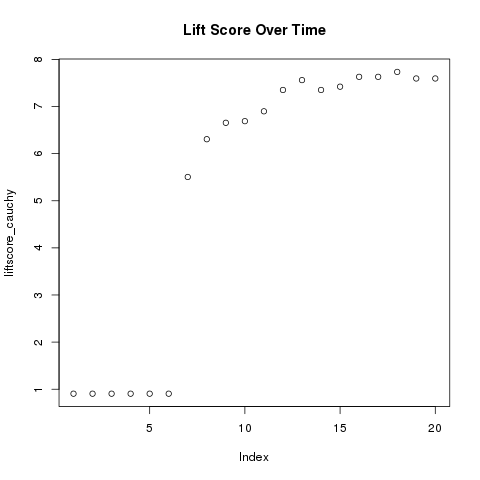

In [46]:
%%R
plot(liftscore_cauchy,main='Lift Score Over Time')

In [47]:
%%R
liftscore_cauchy_mean <- rep(0,20)
#model1 <- vector("list", 20)
predicted_cauchy <- vector("list", 20)
#base2 <- vector("list", 20)
for (i in 1:20){
    model <- bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + NUM_OPPTS + NUM_FORECASTS
                   + NUM_REPORTS + NUM_LEADS + NUM_CASES + NUM_SOLUTIONS +NUM_CASE_QUEUES + NUM_CAMPAIGNS
                   + NUM_CUSTOM_APPS + NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS
                   + NUM_DOCUMENTS + NUM_CONTRACTS +NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES
                   + NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", data = base_s, 
                   maxit=100,prior.mean=1,prior.scale=2.5, prior.df=1)
    display(model)
    predicted1 <- predict(model, testing, type="response")
    base2 <- testing
    base2$label <- testing$testlabel
    base2$predict <- predicted1
    print(liftvalue(base2,0.1)) 
    liftscore_cauchy_mean[i] <- liftvalue(base2,0.1)
}

bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + 
    NUM_OPPTS + NUM_FORECASTS + NUM_REPORTS + NUM_LEADS + NUM_CASES + 
    NUM_SOLUTIONS + NUM_CASE_QUEUES + NUM_CAMPAIGNS + NUM_CUSTOM_APPS + 
    NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS + 
    NUM_DOCUMENTS + NUM_CONTRACTS + NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES + 
    NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", 
    data = base_s, prior.mean = 1, prior.scale = 2.5, prior.df = 1, 
    maxit = 100)
                          coef.est coef.se
(Intercept)               -18.46     7.71 
NUM_ACCOUNTS                0.45     2.41 
NUM_CONTACTS                0.44     2.44 
NUM_OPPTS                   0.35     2.40 
NUM_FORECASTS               0.05     0.93 
NUM_REPORTS                 0.30     2.48 
NUM_LEADS                   0.40     2.40 
NUM_CASES                   0.08     2.28 
NUM_SOLUTIONS               0.21     2.06 
NUM_CASE_QUEUES             0.15  

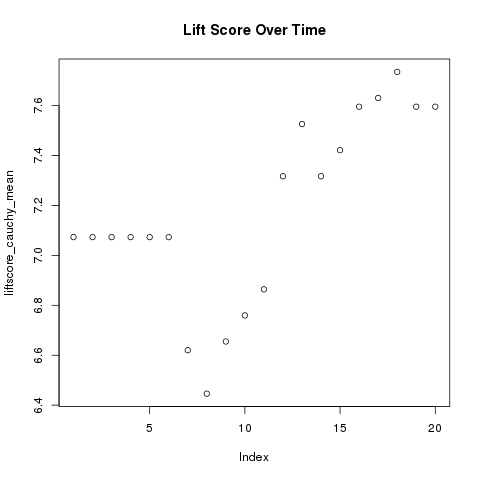

In [49]:
%%R
plot(liftscore_cauchy_mean,main='Lift Score Over Time')

In [50]:
%%R
liftscore_cauchy_mean_smallsd <- rep(0,20)
#model1 <- vector("list", 20)
predicted_cauchy <- vector("list", 20)
#base2 <- vector("list", 20)
for (i in 1:20){
    model <- bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + NUM_OPPTS + NUM_FORECASTS
                   + NUM_REPORTS + NUM_LEADS + NUM_CASES + NUM_SOLUTIONS +NUM_CASE_QUEUES + NUM_CAMPAIGNS
                   + NUM_CUSTOM_APPS + NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS
                   + NUM_DOCUMENTS + NUM_CONTRACTS +NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES
                   + NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", data = base_s, 
                   maxit=100,prior.mean=1,prior.scale=0.1, prior.df=1)
    display(model)
    predicted1 <- predict(model, testing, type="response")
    base2 <- testing
    base2$label <- testing$testlabel
    base2$predict <- predicted1
    print(liftvalue(base2,0.1)) 
    liftscore_cauchy_mean_smallsd[i] <- liftvalue(base2,0.1)
}

bayesglm(formula = label_update[[i]] ~ NUM_ACCOUNTS + NUM_CONTACTS + 
    NUM_OPPTS + NUM_FORECASTS + NUM_REPORTS + NUM_LEADS + NUM_CASES + 
    NUM_SOLUTIONS + NUM_CASE_QUEUES + NUM_CAMPAIGNS + NUM_CUSTOM_APPS + 
    NUM_CUSTOM_TABS + NUM_CUSTOM_OBJECTS + NUM_CUSTOM_OBJECT_RECORDS + 
    NUM_DOCUMENTS + NUM_CONTRACTS + NUM_CASE_RECORD_TYPES + NUM_ESCALATION_RULES + 
    NUM_DASHBOARDS + NUM_EMAIL_TEMPLATES + NUM_VF_PG_TOT, family = "binomial", 
    data = base_s, prior.mean = 1, prior.scale = 0.1, prior.df = 1, 
    maxit = 100)
                          coef.est coef.se
(Intercept)               -72.15     6.39 
NUM_ACCOUNTS                1.00     0.10 
NUM_CONTACTS                1.00     0.10 
NUM_OPPTS                   1.00     0.10 
NUM_FORECASTS               1.00     0.10 
NUM_REPORTS                 1.00     0.10 
NUM_LEADS                   1.00     0.10 
NUM_CASES                   1.00     0.10 
NUM_SOLUTIONS               1.00     0.10 
NUM_CASE_QUEUES             1.00  

In [51]:
%%R
liftscore_cauchy_mean_smallsd

 [1] 0.9756098 0.9756098 0.9756098 0.9756098 0.9756098 0.9756098 5.6097561
 [8] 5.5052265 6.1324042 6.4808362 6.7595819 7.0383275 7.5261324 7.3170732
[15] 7.3867596 7.5609756 7.5609756 7.8397213 7.5609756 7.6306620


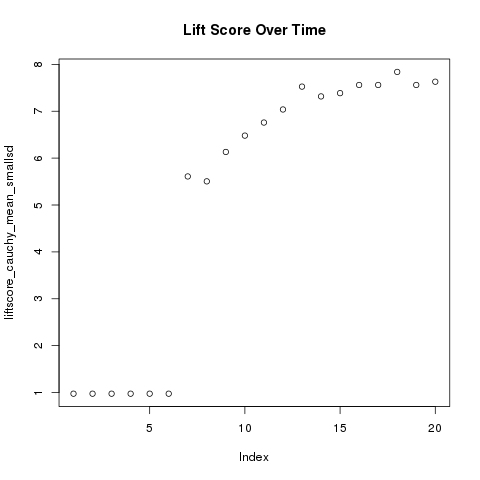

In [52]:
%%R
plot(liftscore_cauchy_mean_smallsd,main='Lift Score Over Time')

In [41]:
%%R
liftscore_expert <- rep(0,20)
#model1 <- vector("list", 20)
#predicted_expert <- vector("list", 20)
base2 <- testing
base2$label <- testing$testlabel
base2$predict <- base2$NUM_ACCOUNTS + base2$NUM_CONTACTS + base2$NUM_OPPTS + base2$NUM_FORECASTS
                   + base2$NUM_REPORTS + base2$NUM_LEADS + base2$NUM_CASES + base2$NUM_SOLUTIONS 
                   + base2$NUM_CASE_QUEUES + base2$NUM_CAMPAIGNS
                   + base2$NUM_CUSTOM_APPS + base2$NUM_CUSTOM_TABS + base2$NUM_CUSTOM_OBJECTS 
                   + base2$NUM_CUSTOM_OBJECT_RECORDS + base2$NUM_DOCUMENTS + base2$NUM_CONTRACTS 
                   + base2$NUM_CASE_RECORD_TYPES + base2$NUM_ESCALATION_RULES
                   + base2$NUM_DASHBOARDS + base2$NUM_EMAIL_TEMPLATES + base2$NUM_VF_PG_TOT
for (i in 1:20){
    #base2$predict <- base_s$predicted_expert
    #print(liftvalue(base2,0.1)) 
    liftscore_expert[i] <- liftvalue(base2,0.1)   
}

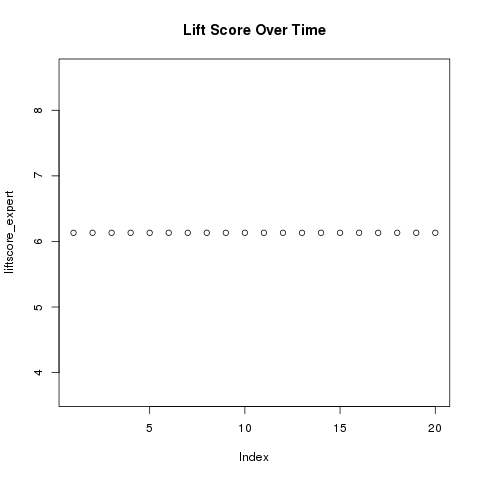

In [54]:
%%R
plot(liftscore_expert,main='Lift Score Over Time')

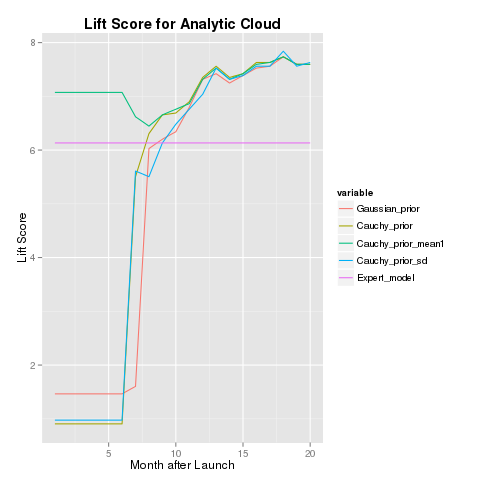

In [55]:
%%R
library(ggplot2)
library(reshape2)
Gaussian_prior <- liftscore
Cauchy_prior <- liftscore_cauchy
Cauchy_prior_mean1 <- liftscore_cauchy_mean
Cauchy_prior_sd <- liftscore_cauchy_mean_smallsd
Expert_model <- liftscore_expert
# original data in a 'wide' format
x <- seq(1, 20, 1)
df1 <- data.frame(x,Gaussian_prior,Cauchy_prior,Cauchy_prior_mean1,Cauchy_prior_sd,Expert_model)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+ coord_fixed(ratio = 4)+ 
ggtitle("Lift Score for Analytic Cloud") + theme(plot.title = element_text(lineheight=.8, face="bold"))+ 
xlab("Month after Launch") +ylab("Lift Score") 